In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer
from hf_olmo import OLMoTokenizerFast
import numpy as np
import os

model = 'gpt2-xl'

def convert_layer(index):
    index = index.split('.')[-1]
    try: 
        return int(index)
    except:
        if model == 'gpt2-xl':
            return 48
        return 32 # default value for final layer
    
def get_tokenizer(model_name):
    tokenizer = None
    if model_name == 'gpt2-xl':
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    elif model_name == 'Llama-2-7b':
        tokenizer = AutoTokenizer.from_pretrained('/data/akshat/models/Llama-2-7b-hf')
    elif model_name == 'pythia-6.9b' :
        tokenizer = AutoTokenizer.from_pretrained('/data/akshat/models/pythia-6.9b')
    else:
        tokenizer = OLMoTokenizerFast.from_pretrained("allenai/OLMo-7B", cache_dir="/data/akshat/models/")
    return tokenizer

output_df = []
tokenizer = get_tokenizer(model)
pos_tags = ['REASONING']
# pos_tags = ['REASONING', 'REASONING_second', 'REASONING_third']

for pos_tag in pos_tags: 
    path = f'out/data/{model}_causal_small_{pos_tag}.csv'
    if not os.path.exists(path):
        print(path + ' does not exist')
        continue
    new_df = pd.read_csv(path)
    new_df['layer'] = new_df['layer'].apply(convert_layer)
    new_df['type'] = pos_tag

    if 'answer_text' in new_df:
        new_df['answer_length'] = new_df['answer_text'].apply(lambda text : len(tokenizer.encode(text)) - 1)
        
    output_df.append(new_df)

output_df = pd.concat(output_df)

output_df.head()

,layer,prompt index,prompt,probability,prob_change,type
0,0,5,London is located in the continent of,0.000030,-0.259044,REASONING
1,1,5,London is located in the continent of,0.000011,-0.259063,REASONING
2,2,5,London is located in the continent of,0.000348,-0.258726,REASONING
3,3,5,London is located in the continent of,0.000008,-0.259066,REASONING
4,4,5,London is located in the continent of,0.002500,-0.256574,REASONING


In [21]:
output_df.shape

(3234, 6)

In [15]:
averaged_output = output_df.groupby(['type', 'layer']).agg({
    'probability': 'mean',
    'prob_change': 'mean'
}).reset_index()

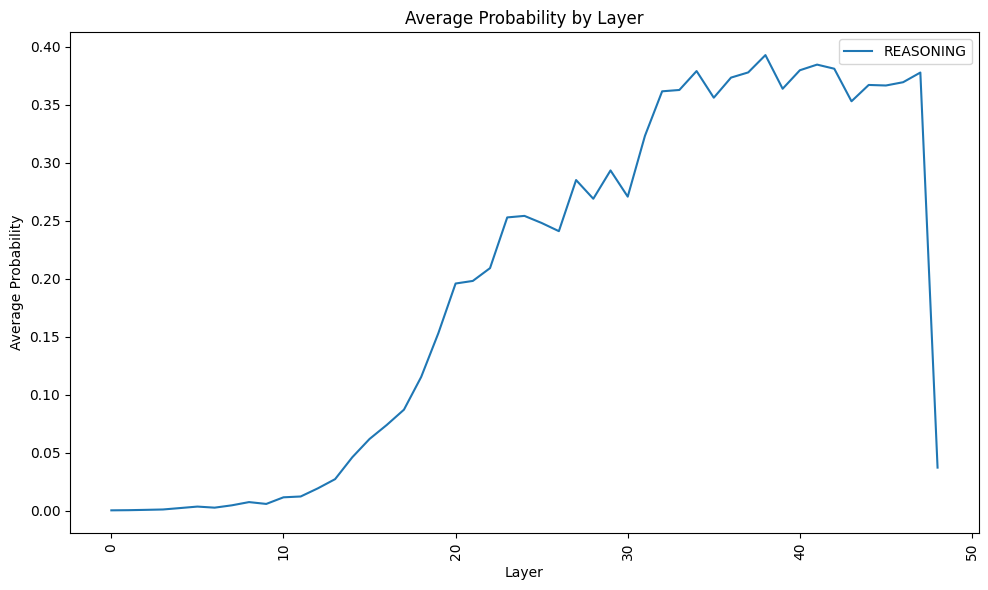

In [19]:
plt.figure(figsize=(10, 6))
for type_label in ['REASONING']: 
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df['layer'], df['probability'], label=type_label)
plt.xlabel('Layer')
plt.ylabel('Average Probability')
plt.title('Average Probability by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

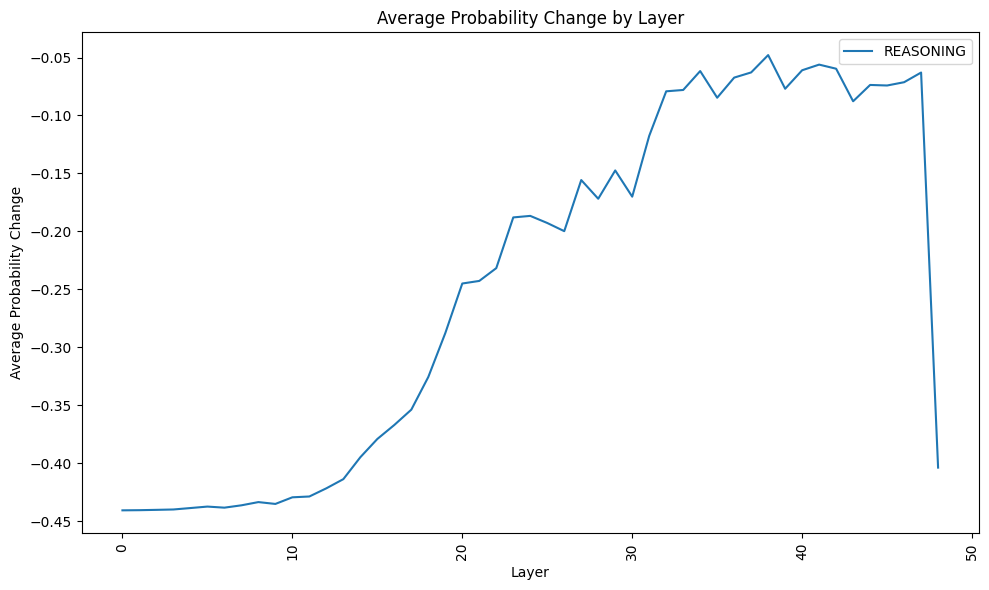

In [20]:
plt.figure(figsize=(10, 6))
for type_label in ['REASONING']: 
    df = averaged_output[averaged_output['type'] == type_label]
    plt.plot(df['layer'], df['prob_change'], label=type_label)
plt.xlabel('Layer')
plt.ylabel('Average Probability Change')
plt.title('Average Probability Change by Layer')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()